# 3b. Fitting carbonate and SO$_2$ peaks
- This notebook shows how to fit secondary peaks, such as carbonate and S-rich phases in vapour bubbles and fluid inclusions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
from tqdm import tqdm
pf.__version__

'0.0.70'

In [2]:
meta_path, spectra_path, filetype, prefix, prefix_str, file_ext, TruPower=pf.get_settings()

In [3]:
exclude_str=['Ne', 'NE', 'Si', 'nodiad', 'Spec', 'CRR', 'secphase']
Diad_Files=pf.get_files(path=spectra_path, file_ext=file_ext, exclude_str=exclude_str)
print(Diad_Files)
File_df=pd.DataFrame(data={'filename': Diad_Files})

['LL4-FI1-#1.txt', 'LL4-FI1-#2 (1).txt', 'LL4-FI1-#2.txt', 'LL7-107-FI#1.txt', 'LL7-107-FI#2_12mW1acc.txt', 'LL7-107-FI#2_6mW.txt', 'LL7-109-FI.txt', 'LL7-FI33.txt', 'LL7-FI34.txt', 'LL8-245.txt', 'LL8-433-FI_12mW.txt', 'LL8-433-FI_6mW.txt']


## Plot spectra in a given region of space to examine secondary peaks or not

### You'll need to tweak the peak parameters to find them
- height = minimum height a peak should have to be identified
- threshold = required vertical distance between a peak and its neighbours
- distance = required horizontal distance bewteen neighbouring peaks. 
- prominence = required prominence of peaks
- width = width of peaks


## Best method - uses scipy find peaks, with the same peak parameters as used throughout Diad Fit

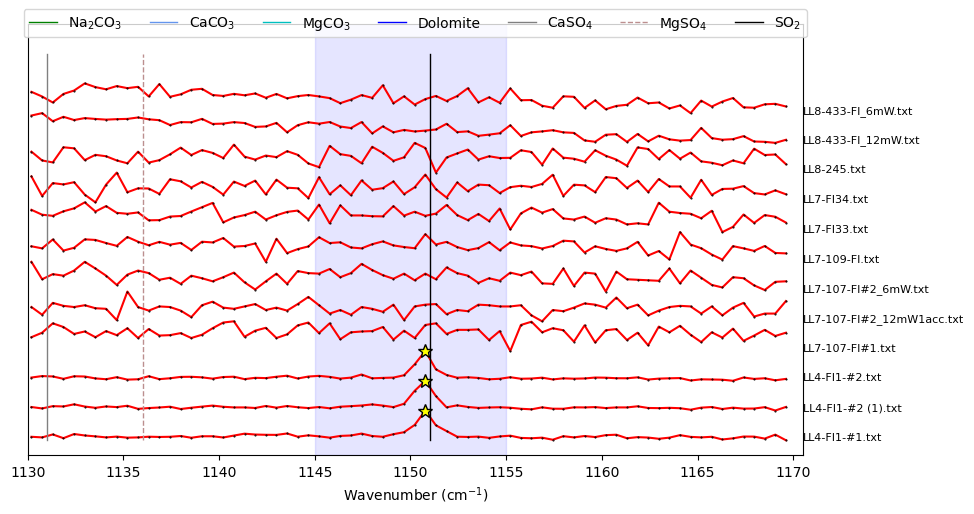

In [22]:
prominence_SO2=60
height_SO2=20
width_SO2=1
threshold_SO2=1

SO2_peaks_scipy, x_data_scipy, y_data_scipy, fig_scipy=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
filetype=filetype, find_peaks_filter=True,  
xlim_peaks=[1145, 1155], xlim_plot=[1130, 1170], yscale=0.3,
prominence=prominence_SO2, height=height_SO2, width=width_SO2, threshold=threshold_SO2)

SO2_peaks=SO2_peaks_scipy

## Find peaks filtering on peak position and prominence so just loop through these files

In [23]:
SO2_notNa=np.isnan(SO2_peaks['pos'])
SO2_filter=((SO2_peaks['pos'].between(1140, 1160))&(SO2_peaks['prom']>10))&(~SO2_notNa)
print('Number kept with this filter:')
print(sum(SO2_filter))
print('Number discarded:')
print(sum(~SO2_filter&(~SO2_notNa)))
filenames_SO2=list(File_df['filename'].loc[SO2_filter])
print('filenames with SO2:')
print(filenames_SO2)

Number kept with this filter:
3
Number discarded:
0
filenames with SO2:
['LL4-FI1-#1.txt', 'LL4-FI1-#2 (1).txt', 'LL4-FI1-#2.txt']


### Choose a filename to test peak fits

In [24]:
if sum(SO2_filter)>0:
    filename=filenames_SO2[0]

### Set up configuration file for S peak fitting

generic_peak_config(name='SO2', lower_bck=[1110, 1130], upper_bck=[1160, 1180], model_name='Spline', x_range_bck=5, N_poly_carb_bck=1, amplitude=1000, cent=1150, outlier_sigma=12, distance=10, prominence=5, width=6, threshold=0.1, height=100, exclude_range=None, return_other_params=False, N_peaks=1)


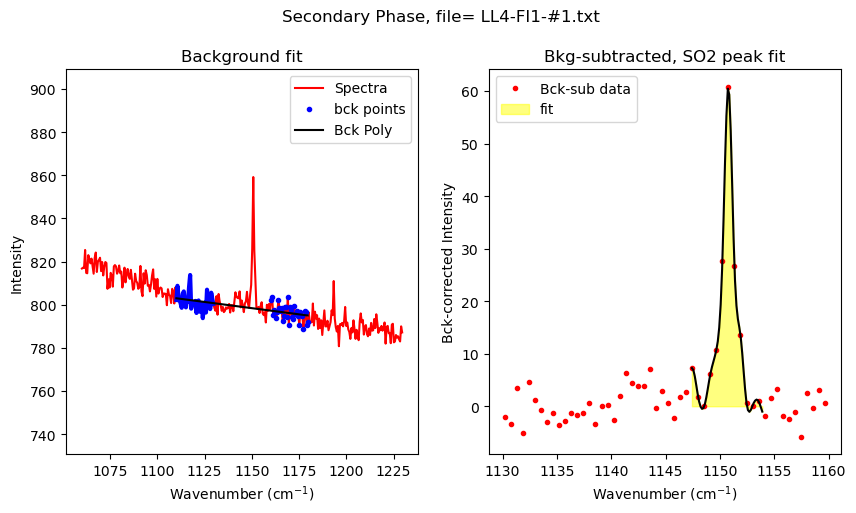

In [25]:
if sum(SO2_filter)>0:
    SO2_peak_config=pf.generic_peak_config(name='SO2', lower_bck=[1110, 1130],
    upper_bck=[1160, 1180], cent=1150, x_range_bck=5, N_peaks=1,   model_name='Spline')
    print(SO2_peak_config)

    SO2_peak_fit=pf.fit_generic_peak(config=SO2_peak_config, 
    path=spectra_path, filename=filename, filetype=filetype,
 
     plot_figure=True)



## Now lets loop through files

100%|██████████| 3/3 [00:00<00:00,  3.93it/s]


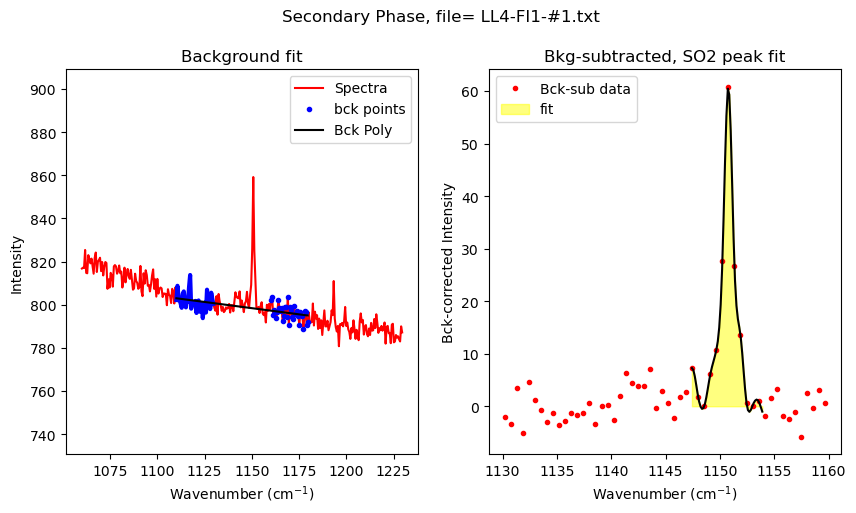

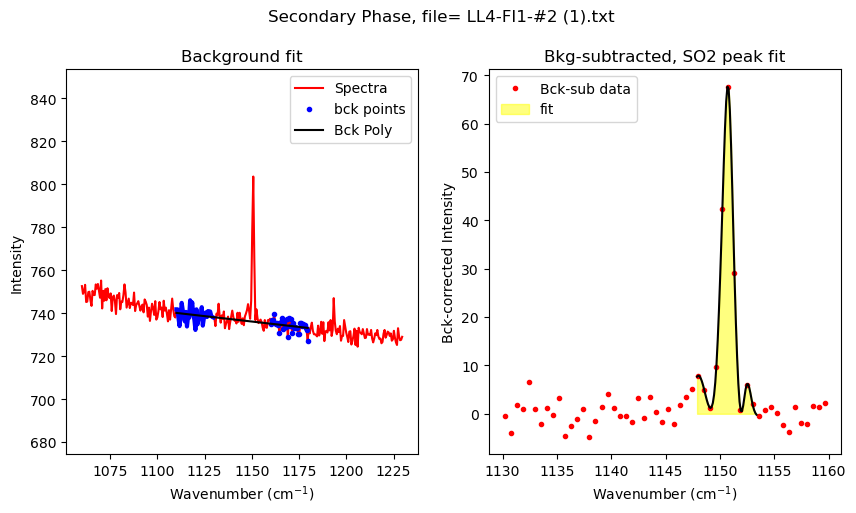

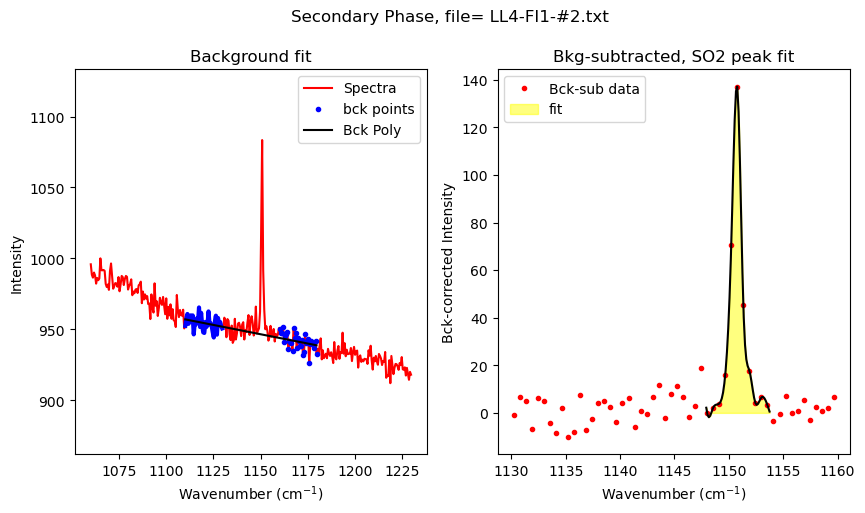

In [26]:
files_to_fit=filenames_SO2
plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
close_figure=False # Means shows figures in the notebook itself

df_Merge_SO2 = pd.DataFrame([])

for i in tqdm(range(0, len(files_to_fit))): #
    
    ## Diad 1 fit
    filename=files_to_fit[i]

    SO2_peak_fit=pf.fit_generic_peak(config=SO2_peak_config, 
path=spectra_path, filename=filename, filetype=filetype,
 plot_figure=plot_figure)
 
    df_Merge_SO2 = pd.concat([df_Merge_SO2, SO2_peak_fit], axis=0)

### Plot peak areas and peak heights

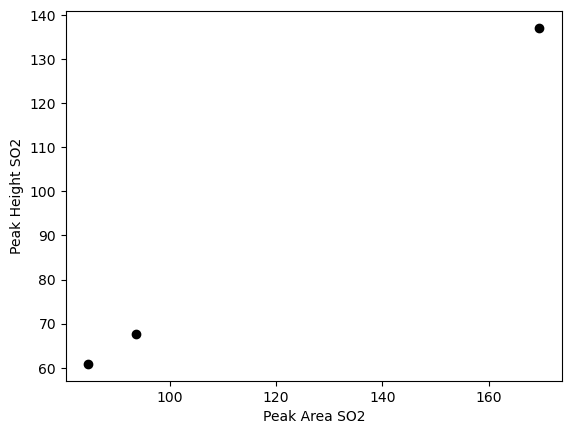

In [27]:
if sum(SO2_filter)>0:
    plt.plot(df_Merge_SO2['Peak_Area_SO2'], 
            df_Merge_SO2['Peak_Height_SO2'], 'ok')
    plt.xlabel('Peak Area SO2')
    plt.ylabel('Peak Height SO2')
    # plt.yscale('log')
# plt.xscale('log')

### Save this to excel

In [28]:
if sum(SO2_filter)>0:
    df_Merge_SO2.to_excel('SO2_Peak_fits.xlsx', index=False)

## Now do the same to ID any carbonate peaks

## Using scipy find peaks methods

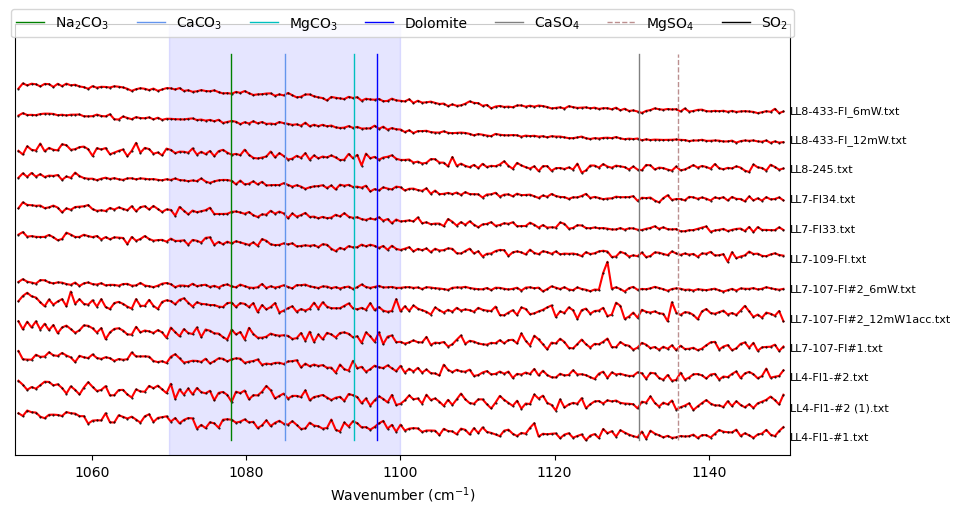

In [30]:

prominence_carb=30
height_carb=10
width_carb=5
threshold_carb=1

Carb_peaks_scipy, x_data_scipy, y_data_scipy, fig=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
 filetype=filetype, find_peaks_filter=True,  
xlim_plot=[1050, 1150], xlim_peaks=[1070, 1100], yscale=0.3,
prominence=prominence_carb, height=height_carb, width=width_carb, threshold=threshold_carb)
Carb_peaks=Carb_peaks_scipy

## Find ones with certain peak parameters to include

In [31]:
Carb_noNa=np.isnan(Carb_peaks['pos'])
Carb_filter=((Carb_peaks['pos'].between(1080, 1100))&(Carb_peaks['prom']>10))&(~Carb_noNa)
print('Number kept with this filter:')
print(sum(Carb_filter))
print('Number discarded:')
print(sum(~Carb_filter&(~Carb_noNa)))
filenames_Carb=list(File_df['filename'].loc[Carb_filter])
print('filenames with carb:')
print(filenames_Carb)

Number kept with this filter:
0
Number discarded:
0
filenames with carb:
[]


### Fit one to tweak parameters

In [32]:
if sum(Carb_filter)>0:
    filename_carb=filenames_Carb[0]

    Carb_peak_config=pf.generic_peak_config(name='Carb', lower_bck=[1050, 1070],
    upper_bck=[1120, 1150], cent=1090, x_range_bck=50, N_poly_carb_bck=2, model_name='Spline')
    print(Carb_peak_config)

    Carb_peak_fit=pf.fit_generic_peak(config=Carb_peak_config, 
    path=spectra_path, filename=filename_carb, filetype=filetype,
     plot_figure=True)

### Loop over all carbonate files

In [33]:
files_to_fit=filenames_Carb
plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
close_figure=False # Means shows figures in the notebook itself

df_Merge_Carb = pd.DataFrame([])

for i in tqdm(range(0, len(files_to_fit))): #
    
    ## Diad 1 fit
    filename=files_to_fit[i]

    Carb_peak_fit=pf.fit_generic_peak(config=Carb_peak_config, 
path=spectra_path, filename=filename, filetype=filetype,
 plot_figure=plot_figure)
 
    df_Merge_Carb = pd.concat([df_Merge_Carb, Carb_peak_fit], axis=0)

0it [00:00, ?it/s]


In [34]:
if sum(Carb_filter)>0:
    plt.plot(df_Merge_Carb['Peak_Area_Carb'], 
        df_Merge_Carb['Peak_Height_Carb'], 'ok')
    plt.xlabel('Peak Area Carb')
    plt.ylabel('Peak Height Carb')
# plt.yscale('log')
# plt.xscale('log')

## Save to excel

In [35]:
if sum(Carb_filter)>0:
    df_Merge_Carb.to_excel('Carb_Peak_fits.xlsx', index=False )

In [36]:
df_Merge_Carb

""


In [37]:
df_Merge_SO2

,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name
0,LL4-FI1-#1.txt,1150.775772,84.693737,60.851251,Spline
0,LL4-FI1-#2 (1).txt,1150.716797,93.719106,67.561877,Spline
0,LL4-FI1-#2.txt,1150.746284,169.521071,137.106448,Spline
